# Ensemble Modeling: Figure Panels

In [1]:
import os
from operator import attrgetter

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import roadrunner

import mass
from mass import MassConfiguration, Simulation
from mass.io.json import load_json_model
from mass.util import strip_time
from mass.visualization import (
    plot_ensemble_time_profile, plot_time_profile)

# Configure roadrunner to allow for more output rows
roadrunner.Config.setValue(
    roadrunner.Config.MAX_OUTPUT_ROWS, 1e6)

mass_config = MassConfiguration()
mass_config.decimal_precision = 12
mass_config.solver = "cplex"
mpl.rcsetup.defaultParams["font.family"] = "arial"
print("MASSpy version: " + mass.__version__)

MASSpy version: 0.1.1


In [2]:
# Function to save a figure
def save_figure(filename):
    fig = plt.gca().get_figure()
    filepath = os.path.abspath(os.path.join("data", "figures", filename))
    fig.savefig(fname=filepath)

## Load models

In [3]:
reference_model = load_json_model(
    os.path.abspath(os.path.join(
        "data", "reference_models", "JSON", "Glycolysis_Hb_PYK.json")))

n_binding_steps = 5
n_sites = 5

PYK_ref = reference_model.enzyme_modules.PYK

### Load Ensemble of Models

In [4]:
directory = os.path.abspath(os.path.join("data", "ensemble_models", "JSON"))

models = np.array(sorted([
    load_json_model(os.path.join(directory, filepath))
    for filepath in os.listdir(directory)
    if reference_model.id in filepath], key=attrgetter("id")))

print("Number of models in ensemble: {0}".format(len(models)))

Number of models in ensemble: 215


## Simulation of Ensemble

In [5]:
# Add models to simulation
simulation = Simulation(reference_model, verbose=True)
simulation.add_models(models, disable_safe_load=True)
# Simulate with perturbation
conc_sol_list, flux_sol_list = simulation.simulate(
    models=models, time=(0, 1000),
    perturbations={"kf_ATPM": "kf_ATPM * 1.5"},
    decimal_precision=True)

Successfully loaded MassModel 'Glycolysis_Hb_PYK' into RoadRunner.


### Visualize Ensemble Simulation Results

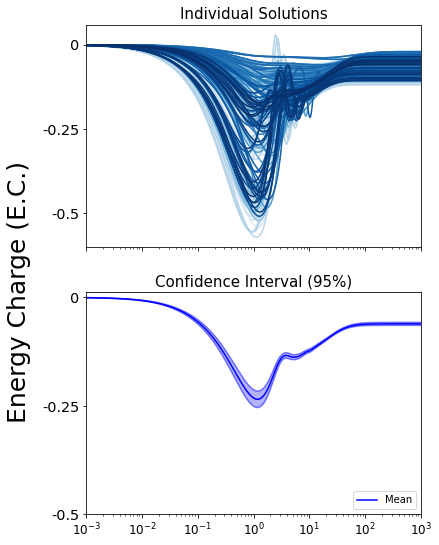

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 9),
                         sharex=True)
(ax1, ax2) = axes.flatten()

colors = [
    mpl.colors.to_hex(color)
    for color in mpl.cm.Blues(
        np.linspace(0, 1, len(conc_sol_list)))]

common_plot_options = {
    "plot_function": "semilogx",
    "xlim": (1e-3, 1e3),
}

ec = "energy_charge"
main_color = "blue"
size_value = 25
for i, conc_sol in enumerate(conc_sol_list):
    conc_sol.make_aggregate_solution(
        ec, equation="(atp_c + 0.5 * adp_c)/(atp_c + adp_c + amp_c)",
        variables=["atp_c", "adp_c", "amp_c"], update=True)

    plot_time_profile(
        conc_sol, observable=ec, ax=ax1,
        title=("Individual Solutions", {"size": size_value - 10}),
        color=colors[i], linestyle="-",
        deviation=True, deviation_zero_centered=True,
        **common_plot_options)

ax2.text(-0.2, 1, "Energy Charge (E.C.)",
         horizontalalignment='center',
         verticalalignment='center',
         rotation=90,
         transform=ax2.transAxes,
         fontdict={"size": size_value})

plot_ensemble_time_profile(
    conc_sol_list, observable=ec, ax=ax2,
    interval_type="CI=95", legend=("Mean", "lower right"),
    title=("Confidence Interval (95%)", {"size": size_value - 10}),
    color=main_color, linestyle="-",
    deviation=True, deviation_zero_centered=True,
    interval_fill_alpha=0.3, interval_border_alpha=0.5,
    **common_plot_options)

for ax in axes:
    ax.set_yticks([-0.5, -0.25, 0])
    ax.set_yticklabels([-0.5, -0.25, 0], fontdict={"size": "x-large"})
ax2.set_xticklabels([r"$10^{%i}$" % np.log10(x) for x in ax2.get_xticks()],
                    fontdict={"size": "large"},
                    rotation=0);
save_figure("ensemble_simulation_results_two_panes.pdf")

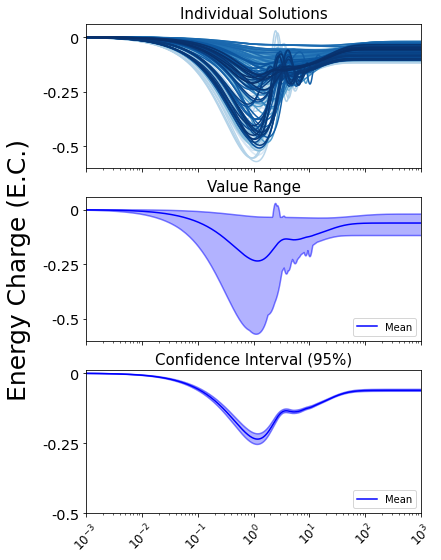

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 9),
                         sharex=True)
(ax1, ax2, ax3) = axes.flatten()

colors = [
    mpl.colors.to_hex(color)
    for color in mpl.cm.Blues(
        np.linspace(0, 1, len(conc_sol_list)))]

common_plot_options = {
    "plot_function": "semilogx",
    "xlim": (1e-3, 1e3),
}

ec = "energy_charge"
main_color = "blue"
size_value = 25
for i, conc_sol in enumerate(conc_sol_list):
    conc_sol.make_aggregate_solution(
        ec, equation="(atp_c + 0.5 * adp_c)/(atp_c + adp_c + amp_c)",
        variables=["atp_c", "adp_c", "amp_c"], update=True)

    plot_time_profile(
        conc_sol, observable=ec, ax=ax1,
        title=("Individual Solutions", {"size": size_value - 10}),
        color=colors[i], linestyle="-",
        deviation=True, deviation_zero_centered=True,
        **common_plot_options)

plot_ensemble_time_profile(
    conc_sol_list, observable=ec, ax=ax2,
    interval_type="range", legend=("Mean", "lower right"),
    title=("Value Range", {"size": size_value - 10}),
    color=main_color, linestyle="-",
    deviation=True, deviation_zero_centered=True,
    interval_fill_alpha=0.3, interval_border_alpha=0.5,
    **common_plot_options)
ax2.text(-0.2, 0.5, "Energy Charge (E.C.)",
         horizontalalignment='center',
         verticalalignment='center',
         rotation=90,
         transform=ax2.transAxes,
         fontdict={"size": size_value})
plot_ensemble_time_profile(
    conc_sol_list, observable=ec, ax=ax3,
    interval_type="CI=95", legend=("Mean", "lower right"),
    title=("Confidence Interval (95%)", {"size": size_value - 10}),
    color=main_color, linestyle="-",
    deviation=True, deviation_zero_centered=True,
    interval_fill_alpha=0.3, interval_border_alpha=0.5,
    **common_plot_options)

for ax in axes:
    ax.set_yticks([-0.5, -0.25, 0])
    ax.set_yticklabels([-0.5, -0.25, 0], fontdict={"size": "x-large"})
ax3.set_xticklabels([r"$10^{%i}$" % np.log10(x) for x in ax3.get_xticks()],
                    fontdict={"size": "large"},
                    rotation=45);
save_figure("ensemble_simulation_results_three_panes.pdf")

## Analysis of Ensemble

### Concentrations

In [8]:
# Simulate with perturbation
conc_sol_list, flux_sol_list = simulation.find_steady_state(
    models=models, strategy="simulate",
    perturbations={"kf_ATPM": "kf_ATPM * 1.5"},
    tfinal=1e5, decimal_precision=True,
    update_values=True)
models = [model for model in simulation.get_model_objects() if model.id != reference_model.id]

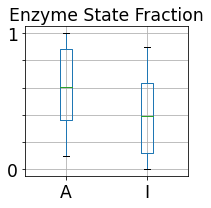

In [9]:
enz_mod_forms = PYK_ref.enzyme_module_forms.list_attr("id")
enz_mod_forms_categorized = PYK_ref.enzyme_module_forms_categorized

df = pd.DataFrame(
    data=[[model.metabolites.get_by_id(e).ic
           for e in enz_mod_forms]
          for model in models],
    columns=enz_mod_forms)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))

active = enz_mod_forms_categorized.get_by_id("PYK_Active")
active = sorted([m.id for m in active.members])

inhibited = enz_mod_forms_categorized.get_by_id("PYK_Inhibited")
inhibited = sorted([m.id for m in inhibited.members])

df_active = df.loc[:, active].sum(axis=1) / df.sum(axis=1)
df_inhibited = df.loc[:, inhibited].sum(axis=1) / df.sum(axis=1)

df_to_plot = pd.concat((df_active, df_inhibited), axis=1)
df_to_plot.columns = ["A", "I"]
ax = df_to_plot.boxplot(ax=ax)

ax.set_title("Enzyme State Fraction",
             fontdict={"size": "xx-large"})
# ax.set_ylabel("Fraction", fontdict={"size": "xx-large"})
ax.set_yticklabels(
    ["", 0, "", "", "", "", 1],
    fontdict={"size": "xx-large"})
ax.set_xticklabels(df_to_plot.columns,
                   fontdict={"size": "xx-large"})
fig.tight_layout()
save_figure("enzyme_state_fraction_AI.pdf")

In [10]:
df_to_plot.A.describe()

count    215.000000
mean       0.594827
std        0.295855
min        0.098615
25%        0.364106
50%        0.607020
75%        0.881163
max        1.000000
Name: A, dtype: float64

### Fluxes

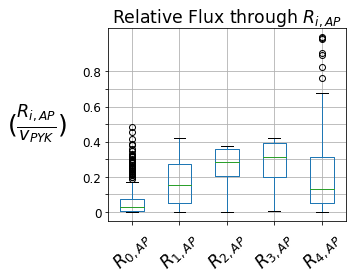

In [11]:
enz_mod_rxns = PYK_ref.enzyme_module_reactions.list_attr("id")
enz_mod_rxns_categorized = PYK_ref.enzyme_module_reactions_categorized

df = pd.DataFrame(
    data=[[model.reactions.get_by_id(e).steady_state_flux
           for e in enz_mod_rxns]
          for model in models],
    columns=enz_mod_rxns)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))


df_net_flux = df.loc[:,  ["PYK_R{0:d}5".format(i)
                          for i in range(0, n_sites)]
                    ].sum(axis=1)

df_fluxes = []
for i in range(0, n_sites):
    PYK_rxn = "PYK_R{0:d}5".format(i)
    df_fluxes += [df.loc[:, PYK_rxn] / df_net_flux] 
    
df_to_plot = pd.concat((df_fluxes), axis=1)
df_to_plot.columns = [i for i in range(0, n_sites)]
ax = df_to_plot.boxplot(ax=ax)

ax.set_title("Relative Flux through $R_{i, AP}$",
             fontdict={"size": "xx-large"})
ax.set_ylabel(r"$(\frac{R_{i, AP}}{v_{PYK}})$" + "\t\t",
              fontdict={"size": 25,
                        "verticalalignment": "center"},
              rotation=0)
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
ax.set_yticklabels(
    [0, "", 0.2, "", 0.4, "", 0.6, "", 0.8],
    fontdict={"size": "large"})

ax.set_xticklabels(["$R_{%s, AP}$" % i for i in range(0, 5)],
                   fontdict={"size": "xx-large"},
                   rotation=45);
fig.tight_layout()
save_figure("enzyme_rel_flux_dist.pdf")

In [12]:
df_to_plot.describe()

,0,1,2,3,4
count,215.000000,2.150000e+02,215.000000,215.000000,215.000000
mean,0.074494,1.812301e-01,0.263695,0.280024,0.200558
std,0.106662,1.412683e-01,0.102036,0.131515,0.210642
min,0.000000,5.477679e-10,0.000002,0.002059,0.000774
25%,0.004124,4.859647e-02,0.204096,0.198966,0.052274
50%,0.025296,1.525334e-01,0.284614,0.314233,0.130633
75%,0.074158,2.718002e-01,0.359200,0.394610,0.310695
max,0.481921,4.218744e-01,0.374989,0.421875,0.997940
